In [1]:
from src.data_structures.instance import Instance
from src.solvers.ZeroReductor.DLHEU2 import DHEU
from src.solvers.ZeroReductor.solver import ZeroReductor2
from src.data_structures.features import *
import torch
from torch import nn
import os
from pathlib import Path
import sys
import numpy as np
import sys
import pickle
from random import shuffle
torch.set_default_tensor_type(torch.DoubleTensor)

/usr/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /build/python-pytorch/src/pytorch-opt/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
def encode_bool_vec(a):
    indices = a.nonzero()
    a-= 1
    indices.T[0]
    a[indices] = 1
    return a

def decode_bool_vec(a):
    a = a + 1
    return a/2
training_data_folder = Path("training_data")
evaluation_data_folder = Path("validation_data")

In [3]:
instances = list(iter(map(Instance.from_file,training_data_folder.iterdir())))
instances.sort(key=lambda x: x.n_items)
instances = iter(instances)
evaluation_instances = list(iter(map(Instance.from_file,evaluation_data_folder.iterdir())))


In [4]:
features: list[ItemBatchFeature] = [
            ProfitOverBudget(),
            LowerCostOverBudget(),
            UpperCostOverBudget(),
            IsInContSol(),
            #CountPSynergiesOverNItems(),
            #CountPSynergiesOverBudget(),
            GammaOverNItems(),
            #SumOfSynergiesByItemOverMaxSinergyProfit(),
            Noise()]

from matplotlib import pyplot as plt

In [5]:
heu = DHEU(features)
heu.load(Path("/home/mixto/repositories/PRKP/src/solvers/ZeroReductor/models/DHEUV2.model"))
#Cargo los pesos del modelo preentrenado

In [10]:
instances = list(iter(map(Instance.from_file,training_data_folder.iterdir())))
instances.sort(key = lambda x: x.n_items ,reverse=False)
instances = iter(instances)


Epoch Presicion 0.9776192846348245 Instance(1695,50,#8792190688741)))

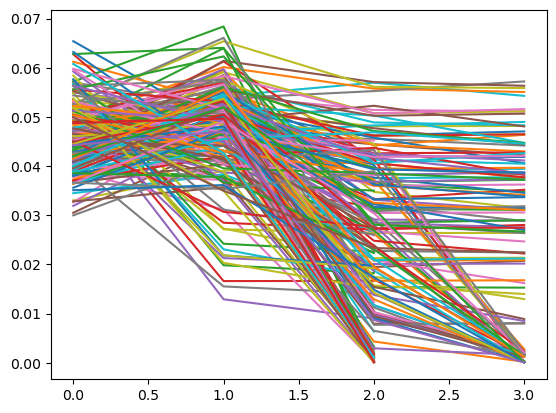

In [38]:
plt.clf()
for o_instance in instances:
    if o_instance.n_items < 1000:
        continue
    loss = []
    stuck = 0
    zr = ZeroReductor2(o_instance)
    zr.heu = heu
    #Actualizo el ruido de una feature para inserta la que depende del estado del solver
    zr.heu.features[-1] = NOverON(o_instance)
    done = False
    while not done:
        instance = zr.instance
        x = heu.gen_x(instance).T
        y = encode_bool_vec(zr.instance.get_feature(IsInOptSol())).view(-1, 1)
        if len(y) == 0:  #Si la instancia no tiene solucion, no se usa :D (Las instancias mas pequeñas tienen ese riesgo)
            continue
        heu.optimizer.zero_grad()
        total_loss = 0
        y_pred = heu.net(x)
        batch_loss = heu.criterion(y_pred, y)
        batch_loss.backward()
        heu.optimizer.step()
        zr.step(max_step=int(zr.instance.n_items/np.log10(zr.instance.n_items)))
        old_n_items = zr.instance.n_items
        if zr.instance.n_items != old_n_items:
            stuck = 0
        else:
            stuck += 1
        if torch.min(zr.actual_pred
                     ) > 0.01 or stuck > 3 or zr.instance.n_items < 150:
            done = True
        total_loss += batch_loss.item()
        loss.append((total_loss / 2, instance))
        sys.stdout.write(
            f'\rEpoch Presicion {1-(total_loss/2)} {str(instance)}')
        sys.stdout.flush()
    plt.plot([i for i in range(len(loss))], [i[0] for i in loss])
    plt.savefig("current_training_loss.png")


In [42]:
heu.save(Path("/home/mixto/repositories/PRKP/src/solvers/ZeroReductor/models/DHEUV2_extended.model"))

In [43]:
for tupla in loss[:2000]:
    print(tupla[0],str(tupla[1]))

0.049933909688905806 Instance(2500,50,#8792192277081)
0.03499075280868216 Instance(1765,50,#8792187665805)
0.023336262503192533 Instance(1698,50,#8792188979521)
0.02238071536517554 Instance(1695,50,#8792190688741)


Presicion 89.923%
STD 1.876%


(array([ 4., 10., 20., 28., 27., 18., 16.,  5.,  3.,  3.]),
 array([0.05937167, 0.06875085, 0.07813003, 0.08750922, 0.0968884 ,
        0.10626758, 0.11564676, 0.12502594, 0.13440512, 0.14378431,
        0.15316349]),
 <BarContainer object of 10 artists>)

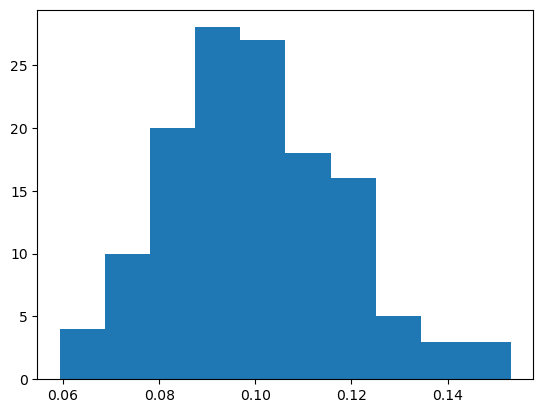

In [44]:
losses = []
with torch.no_grad():
    for instance in evaluation_instances:
        x = heu.gen_x(instance).T
        y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
        if len(y) == 0:
            continue
        y_pred = heu.net(x)
        eval_loss = heu.criterion(y,y_pred)
        losses.append(eval_loss)
precision = (1-np.average(losses))*100
desviacion_estandar = (np.std(losses))*100
print(f"Presicion {np.round(precision,3)}%")
print(f"STD {np.round(desviacion_estandar,3)}%")

plt.hist(losses)